In [14]:
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ARMA process generation

In [2]:
np.random.seed(42)
ma2 = np.array([1,0.9, 0.3])
ar2 = np.array([1, -0.33, -0.5])

In [3]:
ARMA_2_2 = ArmaProcess(ar2,ma2).generate_sample(nsample=10000)
ARMA_2_2

array([ 0.49671415,  0.47269411,  1.07661104, ..., -2.84823217,
       -2.49835551, -1.36959095])

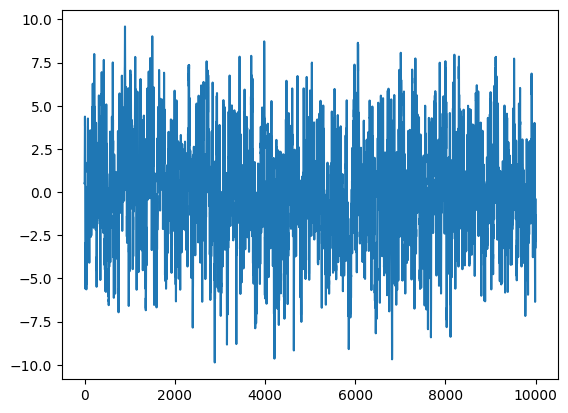

In [4]:
plt.plot(range(len(ARMA_2_2)), ARMA_2_2)

# Test for stationarity 

In [5]:
adfuller(ARMA_2_2)[1] < 0.05

True

In [6]:
train, test = ARMA_2_2[:-200], ARMA_2_2[-200:]

In [7]:
pq_index = list(product(range(4),range(3)))

# Models optimization

In [8]:
def optimize_ARMA(data, index_list):
    results = []
    for p,q in index_list:
        model = SARIMAX(data, order=(p,0,q), simple_differencing=False).fit(disp=False)
        aic = model.aic
        results.append([(p,q), aic])
    df_res = pd.DataFrame(results)
    df_res.columns = ['(p,q)', 'AIC']
    return df_res
        

In [9]:
optimize_ARMA(train, pq_index)

/home/miguelpi/anaconda3/envs/time-series/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,"(p,q)",AIC
0,"(0, 0)",48888.919500
1,"(0, 1)",39283.889819
2,"(0, 2)",33430.468889
3,"(1, 0)",28852.099056
4,"(1, 1)",28085.205818
5,"(1, 2)",27965.143311
6,"(2, 0)",28011.840379
7,"(2, 1)",28010.581548
8,"(2, 2)",27905.573367
9,"(3, 0)",28008.899430


In [10]:
model_chosen =  SARIMAX(train, order=(2,0,2), simple_differencing=False).fit(disp=False)

In [11]:
residuals = model_chosen.resid

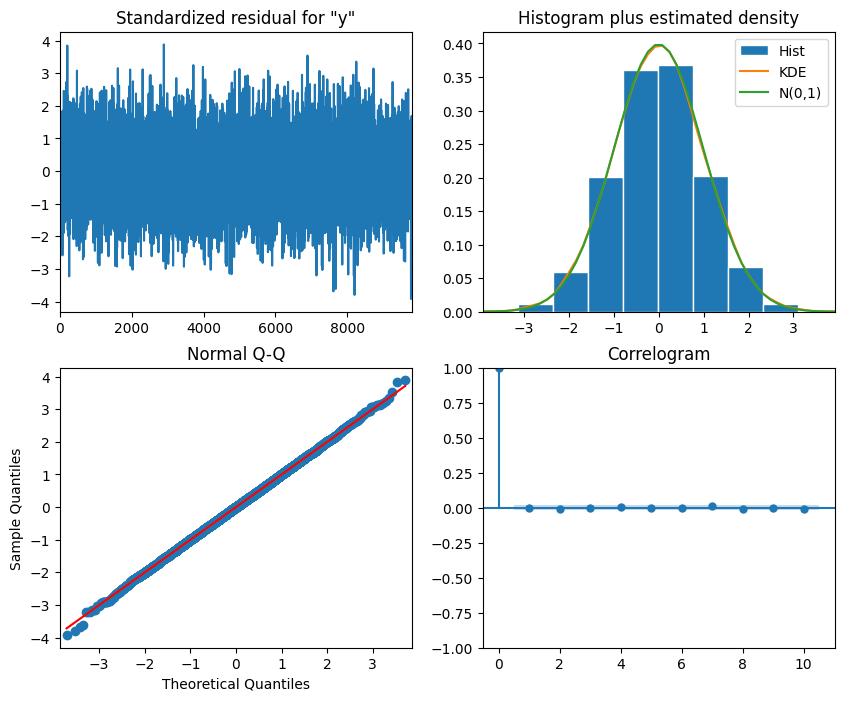

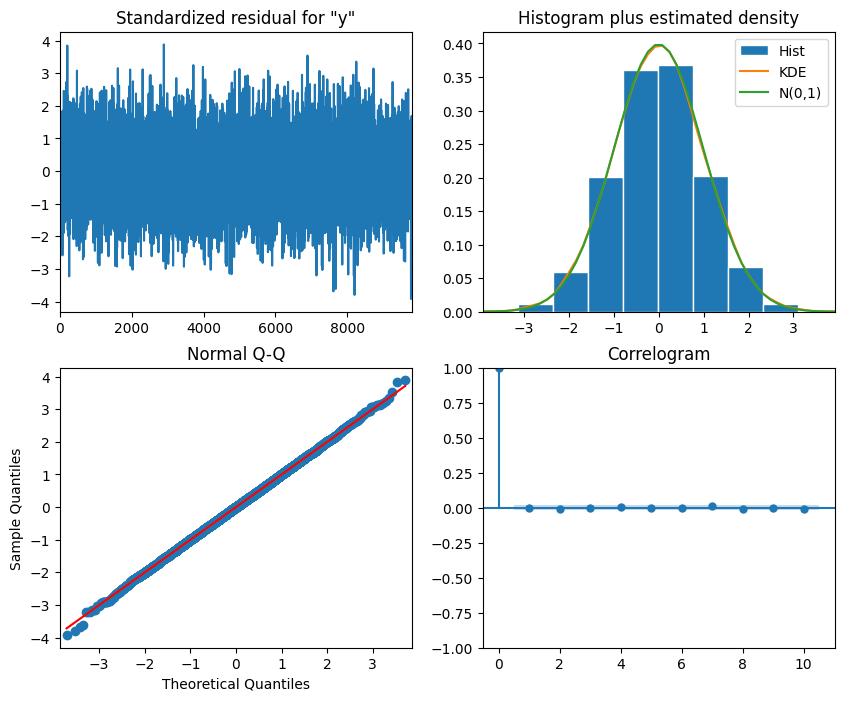

In [13]:
model_chosen.plot_diagnostics(figsize=(10,8))

In [15]:
acorr_ljungbox(residuals, range(1,11))

,lb_stat,lb_pvalue
1,0.042296,0.837056
2,0.414491,0.812820
3,0.514013,0.915802
4,0.819529,0.935811
5,0.819685,0.975761
6,1.075739,0.982577
7,2.077897,0.955403
8,3.083728,0.928994
9,3.102822,0.960078
10,3.415384,0.969894


In [16]:
def recursive_forecast_ARMA(df, train_len, window, p,q):
    test_len = len(df) - train_len
    forecast = []
    for i in range(train_len, len(df), window):
        model = SARIMAX(df[:i], order=(p,0,q))
        res = model.fit(disp=False)
        predictions = res.get_prediction(0, i + window - 1)
        oos_pred = predictions.predicted_mean.iloc[-window:]
        forecast.extend(oos_pred)
    return forecast

In [19]:
ARMA_forecast =recursive_forecast_ARMA(pd.DataFrame(ARMA_2_2), 9800, 2,2,2)

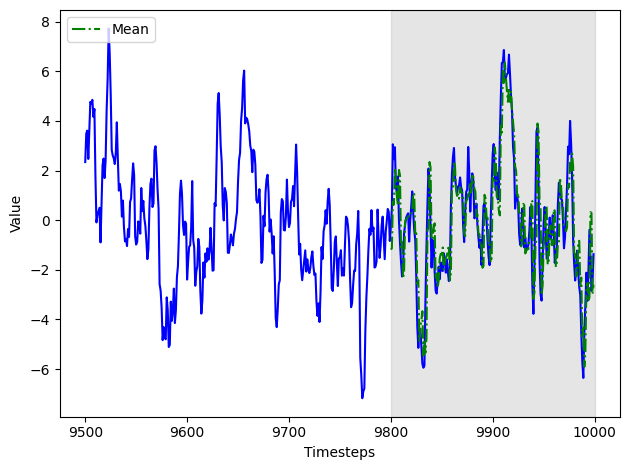

In [27]:
fig, ax = plt.subplots()

ax.plot(range(9500,10000),ARMA_2_2[9500:], 'b-')
ax.plot(range(9800,10000),ARMA_forecast, 'g-.', label='Mean')


ax.axvspan(9800, 10000, color='#808080', alpha=0.2)
ax.legend(loc=2)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()